# Import packages

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.model_selection import KFold
from pylab import * 

 # EXPERIMENT 1: SIMPLE CLASSIFICATION OF PDEs based on classes

## y_class : PDEs from class 1 to class 8
## y_tt: Based on presence of Utt
## y_t: Based on presence of Ut
## y_x: Based on presence of (B_x u_x + B_y u_y)

X:  (3072, 43)


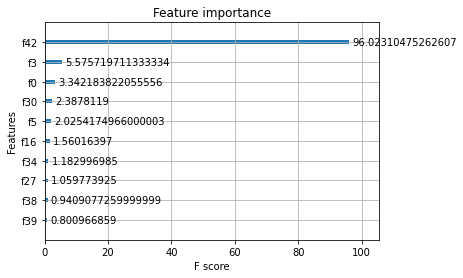

Accuracy on train data: 100.0%
Accuracy on test data: 100.0%


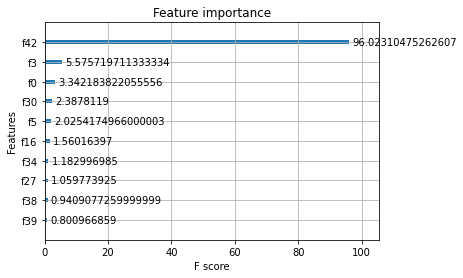

Accuracy on train data: 100.0%
Accuracy on test data: 100.0%


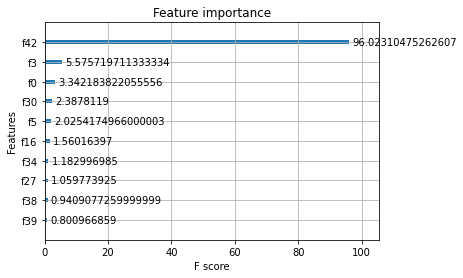

Accuracy on train data: 100.0%
Accuracy on test data: 100.0%


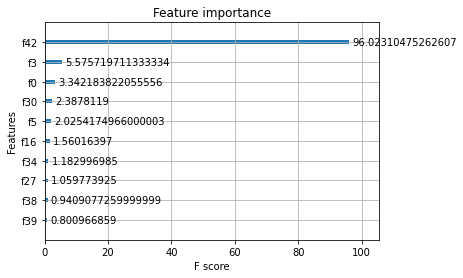

Accuracy on train data: 100.0%
Accuracy on test data: 100.0%


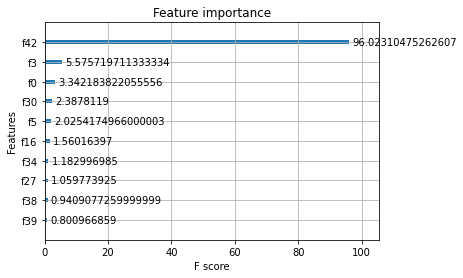

Accuracy on train data: 100.0%
Accuracy on test data: 100.0%
Kfold accuracy:  100.0
Kfold accuracy std :  0.0


In [11]:
############### LOAD FEATURES 
stat = np.load('./FEATURES/Time_signal_stats.npy' , allow_pickle=True)
fft_max = np.load('./FEATURES/FFT_MAX.npy' , allow_pickle=True)
fft_mean = np.load('./FEATURES/FFT_MEAN.npy', allow_pickle=True)
fft_min = np.load('./FEATURES/FFT_MIN.npy', allow_pickle=True)
fft_std = np.load('./FEATURES/FFT_STD.npy', allow_pickle=True)
motion = np.load('./FEATURES/MOTION.npy', allow_pickle=True)
amplitude = np.load('./FEATURES/AMPLITUDE.npy', allow_pickle=True)
sym = np.load('./FEATURES/SYM.npy', allow_pickle=True)
######### FEATURE MATRIX
X = np.concatenate(( stat, fft_max, fft_mean, fft_min, fft_std, motion.reshape(-1,1), amplitude, sym) , axis=1) 
print("X: ", X.shape)
######### LABELS 
df = pd.read_csv ('./labels.csv')
video_id = df['Video_ID']
y_tt = df['label1'].to_numpy().reshape(-1,1)
y_t = df['label2'].to_numpy().reshape(-1,1)
y_x = df['label3'].to_numpy().reshape(-1,1)
y_class = df['label_t'].to_numpy().reshape(-1,1)
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
video_id = video_id[randomize]
y_t = y_t[randomize]
y_tt = y_tt[randomize]
y_x = y_x[randomize]
y_class = y_class[randomize]

dataset = np.concatenate((X,y_class),axis=1)
kfold_accuracy_test =[]

kf = KFold(n_splits= 5 , shuffle=True)
for train_index, test_index in kf.split(dataset): 
    X_train = dataset[train_index,:-1]
    X_test = dataset[test_index,:-1]
    y_train = dataset[train_index,-1]
    y_test = dataset[test_index,-1]
    video_id_train = [video_id[i] for i in train_index]
    video_id_test = [video_id[i] for i in test_index]
    
    train_size = 2500
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y_x[:train_size].reshape(-1)
    y_test = y_x[train_size:].reshape(-1)
    video_id_train = video_id[:train_size]
    video_id_test = video_id[train_size:]
    # fit model on training data
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    # plot feature importance
    features = model.get_booster().get_score(importance_type='gain')
    plot_importance(model, importance_type='gain',max_num_features=10)
    plt.show()

    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    # evaluate on train data
    print('Accuracy on train data: {:.1f}%'.format(accuracy_score(y_train, predictions_train)*100))
    # evaluate on test data
    print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, predictions_test)*100))
    kfold_accuracy_test.append(accuracy_score(y_test, predictions_test)*100)

print("Kfold accuracy: ", np.mean(kfold_accuracy_test) )
print("Kfold accuracy std : ", np.std(kfold_accuracy_test) )


 # EXPERIMENT 2: UNSEEN EQUATIONS PIPELINE 

In [13]:
############### LOAD FEATURES 
stat = np.load('./FEATURES/Time_signal_stats.npy' , allow_pickle=True)
fft_max = np.load('./FEATURES/FFT_MAX.npy' , allow_pickle=True)
fft_mean = np.load('./FEATURES/FFT_MEAN.npy', allow_pickle=True)
fft_min = np.load('./FEATURES/FFT_MIN.npy', allow_pickle=True)
fft_std = np.load('./FEATURES/FFT_STD.npy', allow_pickle=True)
motion = np.load('./FEATURES/MOTION.npy', allow_pickle=True)
amplitude = np.load('./FEATURES/AMPLITUDE.npy', allow_pickle=True)
sym = np.load('./FEATURES/SYM.npy', allow_pickle=True)

### Features used for each term

In [17]:
### Utt for all classes
X_tt = np.concatenate(( fft_max, fft_mean, fft_min, fft_std, motion.reshape(-1,1), amplitude) , axis=1)
#Ut for convection-Diffusion
X_t_1 = np.concatenate((stat[:,1].reshape(-1,1) , stat[:,6].reshape(-1,1)), axis=1)[:1536]
# Ut for Wave Equation
X_t_2 = np.concatenate((amplitude ,motion.reshape(-1,1)) , axis=1)[1536:] 
# Ux for all classes 
X_x = sym
## Dictionary of Equations 
Dict = dict({1: 't_xx', 2:'t_b', 3:'n_xx' , 4:'n_b', 5:'tt_xx' , 6:'tt_b', 7:'b_xx', 8:'b_b'}) 
## Read Labels for Utt
df_tt = pd.read_csv ('./labels.csv')
video_id_tt = df_tt['Video_ID']
y_tt = df_tt['label1'].to_numpy().reshape(-1,1)
## Read Labels for Ut convection
df_t_1 = pd.read_csv ('./labels.csv')[:1536]
video_id_t_1 = df_t_1['Video_ID']
y_t_1 = df_t_1['label2'].to_numpy().reshape(-1,1)
## Read Labels for Ut wave 
df_t_2 = pd.read_csv ('./labels.csv')[1536:]
video_id_t_2 = df_t_2['Video_ID']
y_t_2 = df_t_2['label2'].to_numpy().reshape(-1,1)
## Read Labels for Ux
df_x = pd.read_csv ('./labels.csv')
video_id_x = df_x['Video_ID']
y_x = df_x['label3'].to_numpy().reshape(-1,1)

for i in range(8):
    family = Dict[i+1]
    ####### Utt Test predict
    X_train = X_tt[video_id_tt.str.startswith(family) == False]
    X_test = X_tt[video_id_tt.str.startswith(family)]
    y_train = y_tt[video_id_tt.str.startswith(family) == False].reshape(-1)
    y_test_tt = y_tt[video_id_tt.str.startswith(family)].reshape(-1)
    video_id_train = video_id_tt[video_id_tt.str.startswith(family) == False]
    video_id_test = video_id_tt[video_id_tt.str.startswith(family)]
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    tt_pred = model.predict(X_test)
    
    ####### Ut Test predict
    if i<4:
        X_train = X_t_1[video_id_t_1.str.startswith(family) == False]
        X_test = X_t_1[video_id_t_1.str.startswith(family)]
        y_train = y_t_1[video_id_t_1.str.startswith(family) == False].reshape(-1)
        y_test_t = y_t_1[video_id_t_1.str.startswith(family)].reshape(-1)
        video_id_train = video_id_t_1[video_id_t_1.str.startswith(family) == False]
        video_id_test = video_id_t_1[video_id_t_1.str.startswith(family)]
        model.fit(X_train, y_train)
        t_pred = model.predict(X_test)
        y_t = y_t_1
    elif i>3:
        X_train = X_t_2[video_id_t_2.str.startswith(family) == False]
        X_test = X_t_2[video_id_t_2.str.startswith(family)]
        y_train = y_t_2[video_id_t_2.str.startswith(family) == False].reshape(-1)
        y_test_t = y_t_2[video_id_t_2.str.startswith(family)].reshape(-1)
        video_id_train = video_id_t_2[video_id_t_2.str.startswith(family) == False]
        video_id_test = video_id_t_2[video_id_t_2.str.startswith(family)]
        model.fit(X_train, y_train)
        t_pred = model.predict(X_test)
        y_t = y_t_2
        
    ####### (B_x Ux + B_y Uy) Test predict
    X_train = X_x[video_id_x.str.startswith(family) == False]
    X_test = X_x[video_id_x.str.startswith(family)]
    y_train = y_x[video_id_x.str.startswith(family) == False].reshape(-1)
    y_test_x = y_x[video_id_x.str.startswith(family)].reshape(-1)
    video_id_train = video_id_x[video_id_x.str.startswith(family) == False]
    video_id_test = video_id_x[video_id_x.str.startswith(family)]
    model.fit(X_train, y_train)
    x_pred = model.predict(X_test)
    
    d = {'Video_ID': video_id_test, 'tt_pred': tt_pred, 'tt_y': y_test_tt, 't_pred': t_pred,
         't_y': y_test_t, 'x_pred':x_pred, 'x_y': y_test_x}
    df_test = pd.DataFrame(data=d).sort_index()
    
    if i==0:
        df_results = df_test
    else:
        df_results = pd.concat([df_results, df_test], axis=0)
    
df_results.to_csv('./RESULTS/Experiment2.csv')

# Post Process Results

In [20]:
df = pd.read_csv('./RESULTS/Experiment2.csv')
video_id = df['Video_ID']
tt_pred = df['tt_pred'].to_numpy()
tt_y = df['tt_y'].to_numpy()
t_pred = df['t_pred'].to_numpy()
t_y = df['t_y'].to_numpy()
x_pred = df['x_pred'].to_numpy()
x_y = df['x_y'].to_numpy()

Dict = dict({1: 't_xx', 2:'t_b', 3:'n_xx' , 4:'n_b', 5:'tt_xx' , 6:'tt_b', 7:'b_xx', 8:'b_b'}) 
table = np.zeros((8,8))

for i in range(8):
    family = Dict[i+1]
    data = df[video_id.str.startswith(family)]
    for j in range(384):
        video = data.iloc[j]
        if video['tt_pred'] == 0:
            if video['t_pred'] == 0:
                if video['x_pred'] == 0:
                    table[i,2]+=1
                elif video['x_pred']==1:
                    table[i,3]+=1
            elif video['t_pred'] == 1:
                if video['x_pred'] == 0:
                    table[i,0]+=1
                elif video['x_pred']==1:
                    table[i,1]+=1
        if video['tt_pred'] == 1:
            if video['t_pred'] == 0:
                if video['x_pred'] == 0:
                    table[i,4]+=1
                elif video['x_pred']==1:
                    table[i,5]+=1
            elif video['t_pred'] == 1:
                if video['x_pred'] == 0:
                    table[i,6]+=1
                elif video['x_pred']==1:
                    table[i,7]+=1
        
print(table)

[[383.   0.   0.   0.   0.   0.   1.   0.]
 [  1. 383.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 384.   0.   0.   0.   0.   0.]
 [  0.   0.   5. 379.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 326.  16.  40.   2.]
 [  0.   0.   0.   0.   0. 384.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 384.   0.]
 [  0.   0.   0.   0.   0.  10.   4. 370.]]
